In [1]:
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
DATASET_PATH = Path().absolute() / 'data' / 'Train' / 'markup.csv'
TRAIN_PATH = Path().absolute() / 'data' / 'Train' / 'Images'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

In [4]:
import csv

def read_csv():
        data = []
        with open(DATASET_PATH, 'r', encoding='utf-16') as file:
            reader = csv.reader(file)
            for row in reader:
                path_to_img = TRAIN_PATH.joinpath(row[0])
                row[0] = path_to_img 
                data.append(row)
                
        return data

In [5]:
import cv2

def get_rgb_img(path):
    images = []
    img = cv2.imread(str(path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img_rgb)

    return images

In [6]:
data = read_csv()
len(data)

8199

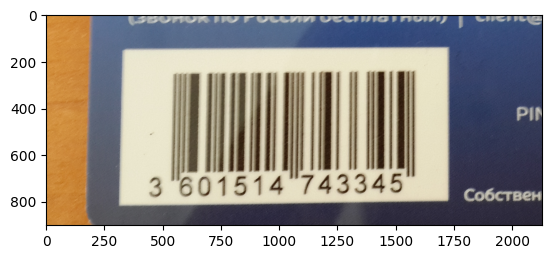

In [7]:
images = get_rgb_img(data[0][0])
plt.imshow(images[0])
plt.show()

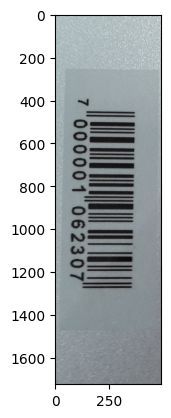

In [8]:
images = get_rgb_img(data[1][0])
plt.imshow(images[0])
plt.show()

### Dataset

In [9]:
import numpy as np

def convert_targets_to_mask(image_shape, corner_coordinates):
    mask = np.zeros(image_shape)
    cv2.fillConvexPoly(mask, np.array(corner_coordinates), 1)
    return mask

In [10]:
import torch
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset, DataLoader

class BarcodeDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dt = self.data[idx]
        img = np.array(get_rgb_img(dt[0])[0])
        img = transforms.ToTensor()(img)

        corner_coordinates = [[int(dt[2]), int(dt[3])], [int(dt[4]), int(dt[5])], [int(dt[6]), int(dt[7])], [int(dt[8]), int(dt[9])]]
        mask = torch.FloatTensor(convert_targets_to_mask(img.size()[1:], corner_coordinates)).unsqueeze(0)

        mask = transforms.Resize((256, 256), interpolation=InterpolationMode.NEAREST)(mask)
        img = transforms.Resize((256, 256))(img)
            
        return img, mask

In [11]:
from torch.utils.data import random_split


train_dataset, val_dataset = random_split(BarcodeDataset(data), lengths=[0.9, 0.1])

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

Train dataset size: 7380
Validation dataset size: 819


In [12]:
batch_size = 16

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

### Model
UNet with skip connections in Block

In [13]:
import torch
import torch.nn as nn

In [14]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.input = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.out = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        return self.out((self.encoder(x) + self.input(x)))

In [15]:
class ResUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enocoder1 = Block(3, 32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enocoder2 = Block(32, 64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enocoder3 = Block(64, 128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enocoder4 = Block(128, 256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = Block(256, 512)
        
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder1 = Block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = Block(256, 128)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder3 = Block(128, 64)
        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder4 = Block(64, 32)
        
        self.out = nn.Conv2d(32, 1, kernel_size=1)
        
        
    def forward(self, x):
        enc1 = self.enocoder1(x)
        enc2 = self.enocoder2(self.pool1(enc1))
        enc3 = self.enocoder3(self.pool2(enc2))
        enc4 = self.enocoder4(self.pool3(enc3))
        
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        dec = self.upconv1(bottleneck)
        dec = torch.cat((dec, enc4), dim=1)
        dec = self.decoder1(dec)
        
        dec = self.upconv2(dec)
        dec = torch.cat((dec, enc3), dim=1)
        dec = self.decoder2(dec)

        dec = self.upconv3(dec)
        dec = torch.cat((dec, enc2), dim=1)
        dec = self.decoder3(dec)
        
        dec = self.upconv4(dec)
        dec = torch.cat((dec, enc1), dim=1)
        dec = self.decoder4(dec)
        
        out = self.out(dec)
        return out

In [16]:
model = ResUNet()
total_params = sum(p.numel() for p in model.parameters())
print("Total params:", total_params)

Total params: 8114241


### Training
I use a combined DiceLoss and BCEWithLogitsLoss

In [17]:
from utils.metrics import CombinationLoss
from lightning.pytorch.loggers import TensorBoardLogger
import lightning

In [18]:
%load_ext tensorboard

In [19]:
class LitBox(lightning.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = CombinationLoss()
        
    def training_step(self, batch, batch_idx):
        inputs, targets = batch

        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        
        self.log("train_loss", loss, on_step=True, on_epoch=False)
        
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch

        outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        
        self.log("val_loss", loss, on_step=False, on_epoch=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.model.parameters(), lr=0.001)
        return optimizer

In [ ]:
lit_model = LitBox(model)
logger = TensorBoardLogger("tb_logs", name="ResUNet")
trainer = lightning.Trainer(logger=logger, max_epochs=2)
trainer.fit(model=lit_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [ ]:
%tensorboard --logdir tb_logs

In [23]:
# torch.save(model.state_dict(), "weights/ResUNet_weights.pth")

In [ ]:
# model.load_state_dict(torch.load("weights/ResUNet_weights.pth"))

### Measure the accuracy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [155]:
class BarcodeTestDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path = self.data[idx]
        img = np.array(get_rgb_img(path)[0])
        img = transforms.ToTensor()(img)
        img_size = img.size()[1:]
        img = transforms.Resize((256, 256))(img)
            
        return img, img_size, path

In [156]:
TEST_PATH = Path().absolute() / 'data' / 'Test' / 'Images'
image_list = list(TEST_PATH.glob('*'))
image_list

test_dataset = BarcodeTestDataset(image_list)

In [157]:
def find_corners(mask):
    binary_mask = (torch.sigmoid(mask) > 0.5).cpu().numpy().astype(np.uint8)
    
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    
    x, y = contour[:, 0, 0], contour[:, 0, 1]
    
    corners_indices = np.array([np.argmin(x + y), np.argmin(-x + y), np.argmax(x + y), np.argmax(-x + y)])
    corners = np.array([x[corners_indices], y[corners_indices]]).T
    
    return corners.astype(float)


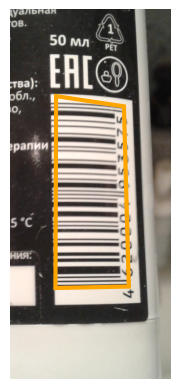

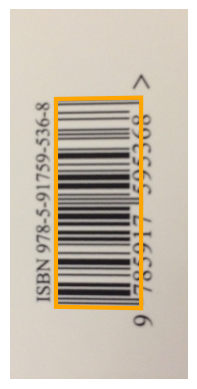

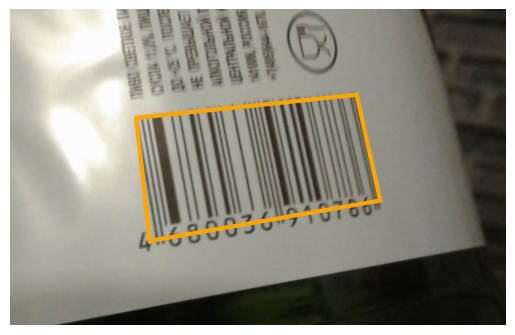

In [158]:
model.eval()
with torch.no_grad():
    for i in range(3):
        img, sz, path = test_dataset[i]
        mask = model(img.to(device).unsqueeze(0))
        mask = transforms.Resize((sz[0], sz[1]), interpolation=InterpolationMode.NEAREST)(mask)
        corners = find_corners(mask.squeeze())
        
        fig, ax = plt.subplots()
        patch = plt.Polygon(corners, facecolor='none', edgecolor='orange', lw=3)
        ax.add_patch(patch)
        images = get_rgb_img(image_list[i])[0]
        plt.imshow(images)
        plt.axis('off')
        plt.show()

In [159]:
corners = []
image_name = []

model.eval()
with torch.no_grad():
    for i in range(len(test_dataset)):
        img, sz, path = test_dataset[i]
        mask = model(img.to(device).unsqueeze(0))
        mask = transforms.Resize((sz[0], sz[1]), interpolation=InterpolationMode.NEAREST)(mask)

        corners.append(find_corners(mask.squeeze()))
        image_name.append(str(path).split('/')[-1])

In [161]:
with open('answer.csv', mode='w', newline='', encoding='utf-16') as file:
    
    for i in range(len(corners)):
        file.write(image_name[i] + ',-,' + ','.join([str(int(j)) for j in np.resize(corners[i], 8)]) + ',-\n')

In [162]:
from course_intro_ocr_t3.evaluate import main

main()

Checking answer (/home/alexey/A4/course_intro_ocr/task3/answer.csv) against markup(/home/alexey/A4/course_intro_ocr/task3/markup.csv)
recognition_accuracy=0.0
detection_result=1.0
score=1.0
